This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import fitter, plot_utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

[ 000000.00 ]: 06-09 11:40  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.10 ]: 06-09 11:40  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.10 ]: 06-09 11:40  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
grid = pd.read_parquet(data_path / "density_data.parquet")
grid_window = pd.read_parquet(data_path / "grid_window_m.parquet")

DataDensity = data_vector.Dens(grid.rename(columns={'density_err': 'density_error', 'rcom': 'rcom_zobs'}).to_dict(orient='list'))

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmag_fiducial = 3.0

power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],
                              [kmt, pmt * np.array(grid_window["window_mt"])],
                              [ktt, ptt]]}


# Fit beta_f 

In [4]:
size_batch=10_000
number_worker=8
covariance_fit = DataDensity.compute_covariance(
    "adamsblake20", power_spectrum_dict, size_batch=size_batch, 
    number_worker=number_worker, additional_parameters_values=(sigmag_fiducial,)
)

/hpc/group/cosmology/blc56/miniconda3/envs/flip/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000015.41 ]: 06-09 11:40  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.52e+01 seconds
[ 000015.44 ]: 06-09 11:40  root            INFO     Use self.init_covariance_sum before using self.compute_covariance_sum.


In [5]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }




minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)
print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['bs8', 'beta_f']


[ 000024.60 ]: 06-09 11:41  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1523                       │              Nfcn = 50               │
│ EDM = 4.49e-09 (Goal: 0.0001)    │            time = 9.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬─────────

{'bs8': 0.8232039166261357, 'beta_f': 0.3079706066107094}

# Fit beta_f with an interpolation scheme for sigma_g

In [6]:
sigmag_list = np.linspace(0.5, 3.0, 10)
covariance_list = []


for sigg in sigmag_list:
    covariance_list.append(
        DataDensity.compute_covariance(
            "adamsblake20", 
            power_spectrum_dict, 
            size_batch=size_batch, 
            number_worker=number_worker, 
            additional_parameters_values=(sigg,)
        )
    )


/hpc/group/cosmology/blc56/miniconda3/envs/flip/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000037.81 ]: 06-09 11:41  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.32e+01 seconds
[ 000037.81 ]: 06-09 11:41  root            INFO     Use self.init_covariance_sum before using self.compute_covariance_sum.
[ 000052.07 ]: 06-09 11:41  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.43e+01 seconds
[ 000052.07 ]: 06-09 11:41  root            INFO     Use self.init_covariance_sum before using self.compute_covariance_sum.
[ 000066.46 ]: 06-09 11:41  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.44e+01 seconds
[ 000066.47 ]: 06-09 11:41  root            INFO     Use self.init_covar

In [7]:
parameter_dict = {"bs8": {"value": 1.0,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "beta_f": {"value": 0.1,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "sigg": {"value": 2.0,
                          "limit_low" : 0.5,
                          "limit_up" : 3.0,
                          "fixed" : False,
                         },
                 }    



likelihood_type = "multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "inverse"}



minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigg",
        interpolation_value_range = sigmag_list,
)

print('Free parameters are:', minuit_fitter_interp.likelihood.free_par)

minuit_fitter_interp.run()


Hello
Free parameters are: ['sigg', 'bs8', 'beta_f']


[ 000276.44 ]: 06-09 11:45  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1524                       │              Nfcn = 126              │
│ EDM = 2.08e-06 (Goal: 0.0001)    │           time = 105.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬─────────

{'bs8': 0.8235270417241396,
 'beta_f': 0.2960542335020141,
 'sigg': 2.85425298006403}

# Some plots

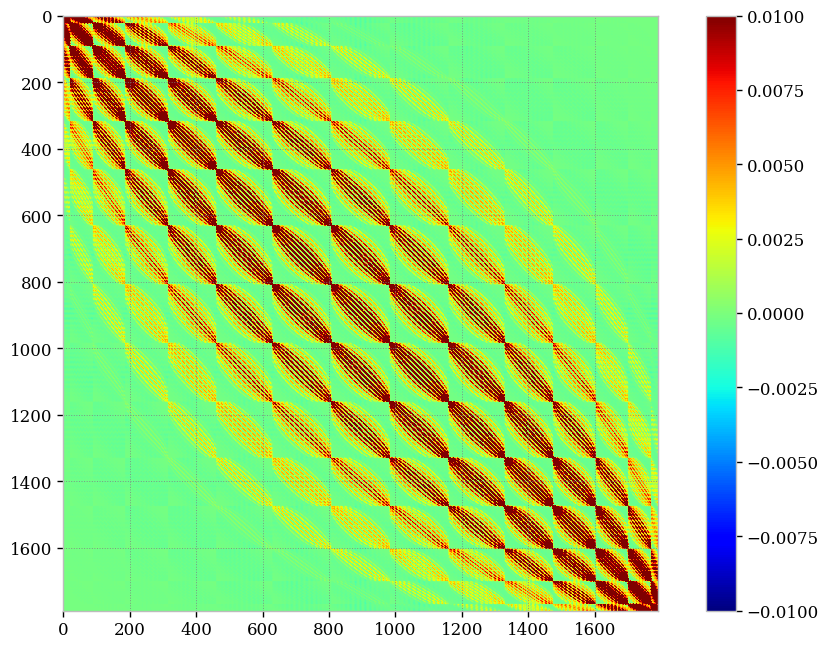

In [8]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter.likelihood,
    parameter_dict, 
    vmin = -0.01, vmax= 0.01
)

/hpc/group/cosmology/blc56/miniconda3/envs/flip/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


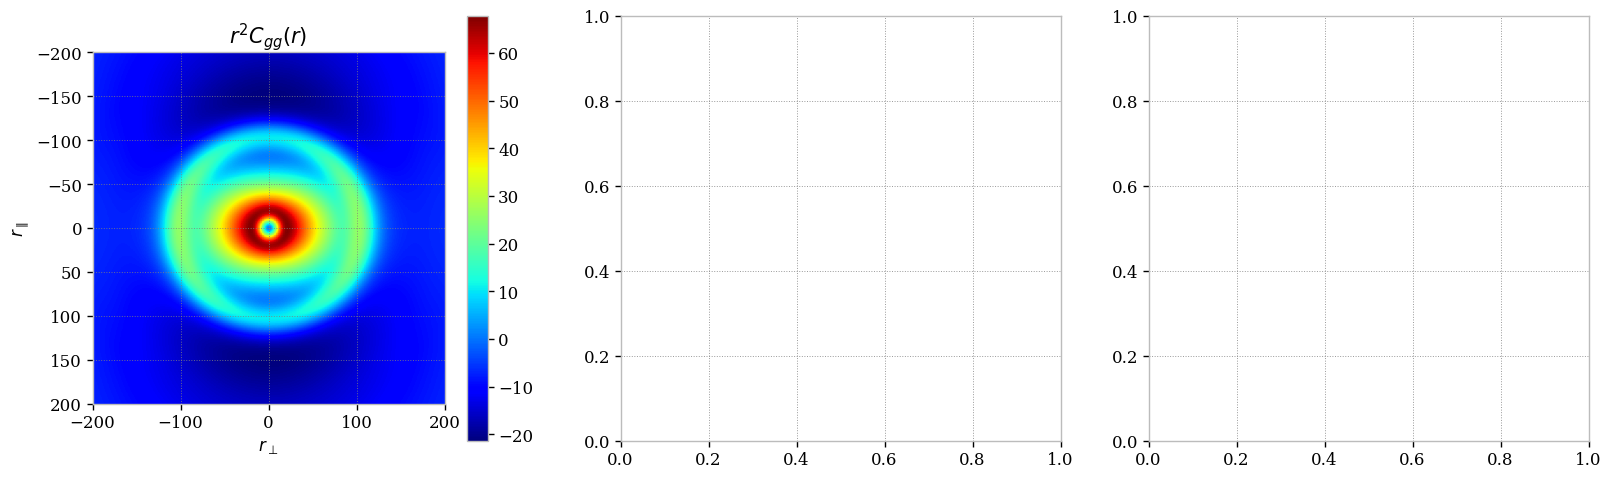

In [9]:
r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "density",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}


plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
